# Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [14]:
def calculate_migration_timestep(D_P, c_t, P_density, K_PF, t_step, V_P, V_F, d_P, d_F, A_PF):
    alpha = (1 / K_PF) * (V_F / V_P)
    d_P = V_P / A_PF        # Annahme, dass das so gilt und das wir einfach nen Zylinder haben 
    upper_alpha = 10

    def calculate_q_n(n, alpha):
        if alpha < 0.1:
            return n * np.pi / (1 + alpha)
        elif alpha > upper_alpha:
            return (2 * n - 1) * np.pi / 2
        else:
            return (n - (alpha / (2 * (1 + alpha)))) * np.pi

    sum_a = 0
    k = 1
    while True:
        q_n = calculate_q_n(k, alpha)
        if alpha > upper_alpha:
            sum_term_i = (2 / q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
        else:
            sum_term_i = (2 * alpha * (1 + alpha)) / (1 + alpha + alpha**2 * q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)

        sum_before = sum_a
        sum_a += sum_term_i

        # Terminierung der unendlichen Summe
        if abs(sum_a - sum_before) < 1e-6:
            break
        k += 1

    # Berechnet Migrationsmenge zu dem Zeitpunkt t_step und Fallunterscheidung abhängig von alpha
    if alpha > upper_alpha:
        migration_amount = c_t * P_density * d_P * (1 - sum_a)
    else:
        migration_amount = c_t * P_density * d_P * (alpha / (1 + alpha)) * (1 - sum_a)

    # Verhindert negative Konzentrationen
    if migration_amount < 0:
        migration_amount = 0

    return migration_amount

def migrationsmodell_piringer_for_curve_fitting(c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, D_P_known):

    D_P = D_P_known

    migration_data = []
    current_time = 0

    while current_time < t_max:
        migration_amount = calculate_migration_timestep(D_P, c_P0, P_density, K_PF, current_time, V_P, V_F, d_P, d_F, A_PF)
        migration_data.append(migration_amount)
        current_time += dt
        
    migration_data = np.array(migration_data) / 10 # Umrechnung in [mg/dm²]

    return migration_data

def plot_results_area(results, t_max, dt, save_path=None): 
    # Plot the area-specific migration results
    plt.figure(figsize=(10, 6))
    time_days = np.arange(0, t_max / (3600 * 24), dt / (3600 * 24))
    plt.plot(time_days, results, linewidth = 2, color = '#F06D1D')
    
    # Plot speichern, wenn ein Pfad angegeben wurde
    if save_path:
        plot_filename = os.path.join(save_path, 'migrated_mass_plot.pdf')
        plt.savefig(plot_filename, bbox_inches='tight')
        print(f"Migrationsplot gespeichert unter: {plot_filename}")
              
    # Achsenbeschriftungen und Titel
    plt.xlabel('Zeit $[Tage]$', fontsize=14)
    # plt.ylabel('spez. Migrationsmenge $[mg/dm^2]$', fontsize=14)
    plt.ylabel('spez. Migrationsmenge $[mg]$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


In [15]:
# Physikalisch-chemische Eigenschaften
# M_r = 136            # relative Molekülmasse des Migranten [g/mol]
# T_C = 20             # Temperatur [°C]
# Material = "PP"   # Material des Polymers [-]

c_P0 = 200           # Anfangskonzentration im Polymer [mg/kg]
P_density = 0.9045   # Dichte des Polymers [g/cm^3]
F_density = 0.9      # Dichte des Fluids [g/cm^3]
K_PF = 1             # Verteilungskoeffizient [-]
t_max = 3600 * 24 * 100   # Simulationszeit [s]

# Geometrische Größen
d_P = None            # Durchmesser des Polymers [cm]
d_F = None            # Durchmesser des Fluids [cm]
A_PF = 0.2827             # Kontaktfläche Polymer/Fluid [dm^2] (nach Norm)
V_P = 28.27    # Volumen des Polymers [cm^3] (von Andre)
V_F = 10.6384    # Volumen des Fluids [cm^3] (von Andre)

D_P_var = 1e-8      # Exemplarischer Diffusionskoeffizient in [cm^2/s]
dt = 100 * 3600

In [16]:
# Umrechnung von Einheiten
# m_P = 

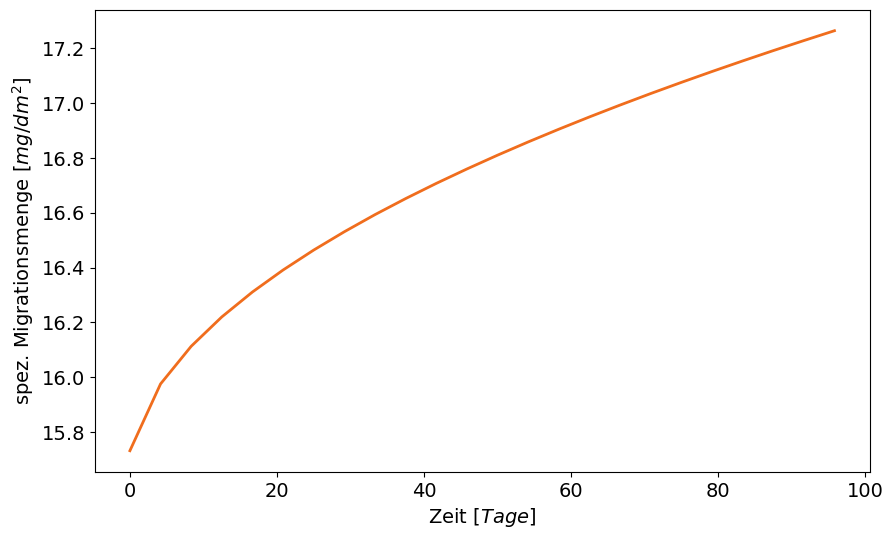

In [17]:
area_specific_migration = migrationsmodell_piringer_for_curve_fitting(c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, D_P_var) # flächenspezifische Migration in [mg/dm^2]
specific_migration = area_specific_migration * A_PF # spezifische Migration (nicht auf die Fläche bezogen) [mg]
plot_results_area(specific_migration, t_max, dt, None)


In [18]:
# Messwerte
time_days = np.array([7, 14, 28]) # Zeitpunkte der Messungen aus Migrationsversuchen in Tagen
time_seconds = time_days * 3600 * 24

migration_amount_messured = [6.4, 10.2, 12.2] # Messwerte der Konzentration (Amberon 60°C) in Kontaktphase in [mg/kg]

In [19]:
# hier Berechnung von D_P
# dafür: D_P so lange variieren und kleineste Fehlerquadrate zwischen berechneten Werten und gemessenen Werten erreicht sind, bis für den Fall adäquater Threshhold erreicht ist.
